In [2]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt

# This next command is specifically for Jupyter Notebook
%matplotlib notebook

pts = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


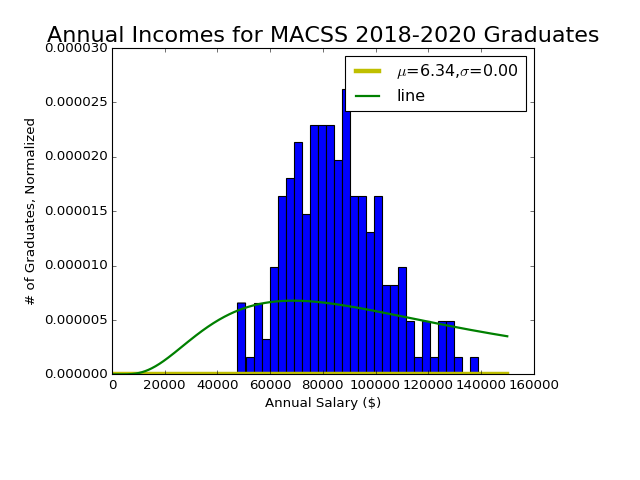

In [155]:

fig, ax = plt.subplots(1, 1)

box = ax.get_position()
ax.set_position([box.x0+0.05, box.y0+0.12, box.width*0.85, box.height * 0.85])

count, bins, ignored = plt.hist(pts, 30, normed = True)

dist_pts = np.linspace(0, 150000, 500)
#plt.plot(dist_pts, sts.lognorm.pdf(dist_pts, loc=mu_GMM1b, s=sig_GMM1b, scale=np.exp(mu_GMM1)), 
#         linewidth=4, color='r', label='line')

plt.plot(dist_pts, sts.lognorm.pdf(dist_pts, loc=mu_GMM2, s=sig_GMM2, scale=np.exp(mu_GMM2)), 
         linewidth=4, color='y', label='$\mu$={:.2f},$\sigma$={:.2f}'.format(mu_GMM2, sig_GMM2))

plt.plot(dist_pts, sts.lognorm.pdf(dist_pts, loc=11.6, s=0.68, scale = np.exp(11.6)), 
         linewidth=2, color='g', label='line')
plt.legend(loc='upper right')

plt.title('Annual Incomes for MACSS 2018-2020 Graduates', fontsize=20)
plt.xlabel('Annual Salary ($)')
plt.ylabel('# of Graduates, Normalized')


In [93]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = np.std(xvals)
    
    return mean_data, std_data


def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * sts.lognorm.pdf(x, loc=mu, s=sigma, scale=np.exp(mu))
    (mean_model, m_m_err) = intgr.quad(xfx, -np.inf, np.inf)
    x2fx = lambda x: ((x - mean_model) ** 2) * sts.lognorm.pdf(x, loc=mu, s=sigma, scale=np.exp(mu))
    (std_model, s_m_err) = np.sqrt(intgr.quad(x2fx, -np.inf, np.inf)) 
    
    return mean_model, std_model


def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [117]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11.3
sig_init = 0.68
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='SLSQP', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1b, sig_GMM1b = results.x
print('mu_GMM1b=', mu_GMM1b, ' sig_GMM1b=', sig_GMM1b)
print('mu_init=', mu_init, 'sig_init=', sig_init )

mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM1b, sig_GMM1b)
err1 = err_vec(pts, mu_init, sig_init, False).reshape(2,)

print('Mean of points =', mean_data, ', Variance of points =', std_data)
print('Mean of model =', mean_model, ', Variance of model =', std_model)
print('Error vector=', err1)

C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised 

mu_GMM1b= 10.2974722166  sig_GMM1b= 0.584593806644
mu_init= 11.3 sig_init= 0.68
Mean of points = 85276.8236063 , Variance of points = 17992.542128
Mean of model = 35096.21330019995 , Variance of model = 22415.7480359
Error vector= [-1.          5.78131518]


In [120]:
mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', std_data)
print('Mean of model =', mean_model, ', Variance of model =', std_model)
print('Error vector=', err1)
fun = results.fun
fun

Mean of points = 85276.8236063 , Variance of points = 17992.542128
Mean of model = 0.0 , Variance of model = 0.0
Error vector= [-1. -1.]


array([[ 0.4067011]])

In [108]:
err1 = err_vec(pts, mu_GMM1, sig_GMM1, False)
VCV2 = np.dot(err1, err1.T) / pts.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


[[ 0.00173133 -0.0007233 ]
 [-0.0007233   0.00030218]]
[[ 418.68668522 -174.91572526]
 [-174.91572526   73.07495563]]


In [111]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11.3
sig_init = 0.68
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='SLSQP', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)
print('mu_init=', mu_init, 'sig_init=', sig_init )

mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(pts, mu_init, sig_init, False).reshape(2,)

print('Mean of points =', mean_data, ', Variance of points =', std_data)
print('Mean of model =', mean_model, ', Variance of model =', std_model)
print('Error vector=', err2)

C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


mu_GMM2= 6.33541995826  sig_GMM2= 1.0142081619e-10
mu_init= 11.3 sig_init= 0.68
Mean of points = 85276.8236063 , Variance of points = 17992.542128
Mean of model = 0.0 , Variance of model = 0.0
Error vector= [-1.          5.78131518]


In [114]:
mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(pts, mu_GMM2, sig_GMM2, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', std_data)
print('Mean of model =', mean_model, ', Variance of model =', std_model)
print('Error vector=', err2)
results

Mean of points = 85276.8236063 , Variance of points = 17992.542128
Mean of model = 0.0 , Variance of model = 0.0
Error vector= [-1. -1.]


     fun: array([[ 141.93019032]])
     jac: array([ 0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 178
     nit: 24
    njev: 22
  status: 0
 success: True
       x: array([  6.33541996e+00,   1.01420816e-10])

In [156]:
def data_moments4(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the three data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < #75,000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 $75,000 <= x < $100,000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 x >= $100,000

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments4(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        sts.lognorm.pdf - from scipy, the lognorml probability distribution function
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: sts.lognorm.pdf(x, loc=mu, s=sigma, scale=np.exp(mu))
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, -np.inf, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, np.inf)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec4(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments4(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion4(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec4(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [135]:
print(data_moments4(pts))
print(model_moments4(11,0.68))
params = np.array([11, 0.68])
print(criterion4(params, pts, np.eye(3)))

(0.3, 0.5, 0.2)


C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


(0.6144034857623427, 0.14493049298685232, 0.22538246616883675)
[[ 16187.32512957]]


In [162]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11.3
sig_init = 0.68
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (pts, W_hat)
results = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='SLSQP', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1d, sig_GMM1d = results.x
print('mu_GMM1d=', mu_GMM1d, ' sig_GMM1d=', sig_GMM1d)
print('mu_init=', mu_init, 'sig_init=', sig_init )

bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments4(pts)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments4(mu_GMM1d, sig_GMM1d)
err1d = err_vec4(pts, mu_GMM1d, sig_GMM1d, False).reshape(3,)

print('Dat_1 points =', bpct_1_dat, 'Dat_2 points =', bpct_2_dat, 'Dat_3 points =', bpct_3_dat)
print('Mod_1 points =', bpct_1_mod, 'Mod_2 points =', bpct_2_mod, 'Mod_3 points =', bpct_3_mod)
print('Error vector=', err1d)

C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


mu_GMM1d= 11.3355446226  sig_GMM1d= 0.210626812956
mu_init= 11.3 sig_init= 0.68
Dat_1 points = 0.3 Dat_2 points = 0.5 Dat_3 points = 0.2
Mod_1 points = 0.3000007042684152 Mod_2 points = 0.49999860772515586 Mod_3 points = 0.2000006880064293
Error vector= [ 0.00023476 -0.00027845  0.000344  ]


In [161]:
results

     fun: array([[  2.50985826e-07]])
     jac: array([ 0.17423374,  0.74957116,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 21
    njev: 18
  status: 0
 success: True
       x: array([ 11.33554462,   0.21062681])

In [146]:
err1d = err_vec4(pts, mu_GMM1d, sig_GMM1d, False)
VCV2 = np.dot(err1d, err1d.T) / pts.shape[0]
print(VCV2)
W_hat3 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat3)

[[  2.75552223e-10  -3.26845066e-10   4.03784331e-10]
 [ -3.26845066e-10   3.87685848e-10  -4.78947022e-10]
 [  4.03784331e-10  -4.78947022e-10   5.91691058e-10]]
[[  1.74970776e+08  -2.07540822e+08   2.56395892e+08]
 [ -2.07540822e+08   2.46173640e+08  -3.04122868e+08]
 [  2.56395892e+08  -3.04122868e+08   3.75713332e+08]]


In [158]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow

params_init = np.array([mu_GMM1d, sig_GMM1d])
gmm_args = (pts, W_hat3)
results = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1e, sig_GMM1e = results.x
print('mu_GMM1e=', mu_GMM1e, ' sig_GMM1e=', sig_GMM1e)
print('mu_init=', mu_GMM1d, 'sig_init=', sig_GMM1d)

bpct_1_dat_e, bpct_2_dat_e, bpct_3_dat_e = data_moments4(pts)
bpct_1_mod_e, bpct_2_mod_e, bpct_3_mod_e = model_moments4(mu_GMM1e, sig_GMM1e)
err1e = err_vec4(pts, mu_GMM1d, sig_GMM1d, False).reshape(3,)

print('Dat_1 points =', bpct_1_dat_e, 'Dat_2 points =', bpct_2_dat_e, 'Dat_3 points =', bpct_3_dat_e)
print('Mod_1 points =', bpct_1_mod_e, 'Mod_2 points =', bpct_2_mod_e, 'Mod_3 points =', bpct_3_mod_e)
print('Error vector=', err1e)

C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


mu_GMM1e= 11.3355417879  sig_GMM1e= 0.210626759407
mu_init= 11.3355446226 sig_init= 0.210626812956
Dat_1 points = 0.3 Dat_2 points = 0.5 Dat_3 points = 0.2
Mod_1 points = 0.30000533738948193 Mod_2 points = 0.49999780237528935 Mod_3 points = 0.19999686023522892
Error vector= [ 0.00023476 -0.00027845  0.000344  ]


In [159]:
results

      fun: array([[  7.82585544e-08]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  213633.2426023 ,  4373658.38107393])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 93
      nit: 3
   status: 0
  success: True
        x: array([ 11.33554179,   0.21062676])